In [26]:
import os
import dotenv
import pandas as pd
from io import StringIO
from azure.identity import DefaultAzureCredential, get_bearer_token_provider
import streamlit as st
from langchain import agents
from langchain_core.prompts import PromptTemplate
from langchain_core.tools import tool
from langchain_openai import AzureChatOpenAI
from langchain.agents import AgentExecutor, create_react_agent, load_tools
from langchain_community.callbacks.streamlit import (
    StreamlitCallbackHandler,
)
import random
from openai import AzureOpenAI

In [27]:
llm: AzureChatOpenAI = None
if "AZURE_OPENAI_API_KEY" in os.environ:
    llm = AzureChatOpenAI(
        azure_endpoint=os.getenv("AZURE_OPENAI_ENDPOINT"),
        api_key=os.getenv("AZURE_OPENAI_API_KEY"),
        azure_deployment=os.getenv("AZURE_OPENAI_COMPLETION_DEPLOYMENT_NAME"),
        openai_api_version=os.getenv("AZURE_OPENAI_VERSION"),
        temperature=0,
        streaming=True
    )
else:
    token_provider = get_bearer_token_provider(DefaultAzureCredential(), "https://cognitiveservices.azure.com/.default")
    llm = AzureChatOpenAI(
        azure_ad_token_provider=token_provider,
        azure_endpoint=os.getenv("AZURE_OPENAI_ENDPOINT"),
        azure_deployment=os.getenv("AZURE_OPENAI_COMPLETION_DEPLOYMENT_NAME"),
        openai_api_version=os.getenv("AZURE_OPENAI_VERSION"),
        temperature=0,
        openai_api_type="azure_ad",
        streaming=True
    )

client: AzureOpenAI

if "AZURE_OPENAI_API_KEY" in os.environ:
    client = AzureOpenAI(
        api_key = os.getenv("AZURE_OPENAI_API_KEY"),  
        api_version = os.getenv("AZURE_OPENAI_VERSION"),
        azure_endpoint = os.getenv("AZURE_OPENAI_ENDPOINT") # f"{os.getenv("AZURE_OPENAI_ENDPOINT")}openai/deployments/{os.getenv("AZURE_OPENAI_COMPLETION_DEPLOYMENT_NAME")}/extensions" 
    )
else:
    token_provider = get_bearer_token_provider(DefaultAzureCredential(), "https://cognitiveservices.azure.com/.default")
    client = AzureOpenAI(
        azure_ad_token_provider=token_provider,
        api_version = os.getenv("AZURE_OPENAI_VERSION"),
        azure_endpoint = os.getenv("AZURE_OPENAI_ENDPOINT"),
    )

deployment_name = os.getenv("AZURE_OPENAI_COMPLETION_DEPLOYMENT_NAME")
computer_vision_endpoint = os.getenv("AZURE_COMPUTER_VISION_ENDPOINT")
computer_vision_key = os.getenv("AZURE_COMPUTER_VISION_KEY")

In [28]:
response = client.chat.completions.create(
    model = deployment_name,
    messages = [{"role" : "assistant", "content" : "The one thing I love more than anything else is "}],
)

print(response)

ChatCompletion(id='chatcmpl-9bVcN7Ap9fYhoB78xrM9HLbwAy2AK', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content="connecting with people and making a positive impact in their lives. There's something incredibly fulfilling about being able to share in the joys, support through challenges, and create meaningful bonds that make life richer and more rewarding.", role='assistant', function_call=None, tool_calls=None), content_filter_results={'hate': {'filtered': False, 'severity': 'safe'}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}})], created=1718726703, model='gpt-4o-2024-05-13', object='chat.completion', system_fingerprint='fp_abc28019ad', usage=CompletionUsage(completion_tokens=41, prompt_tokens=18, total_tokens=59), prompt_filter_results=[{'prompt_index': 0, 'content_filter_results': {}}])


Data URL: 

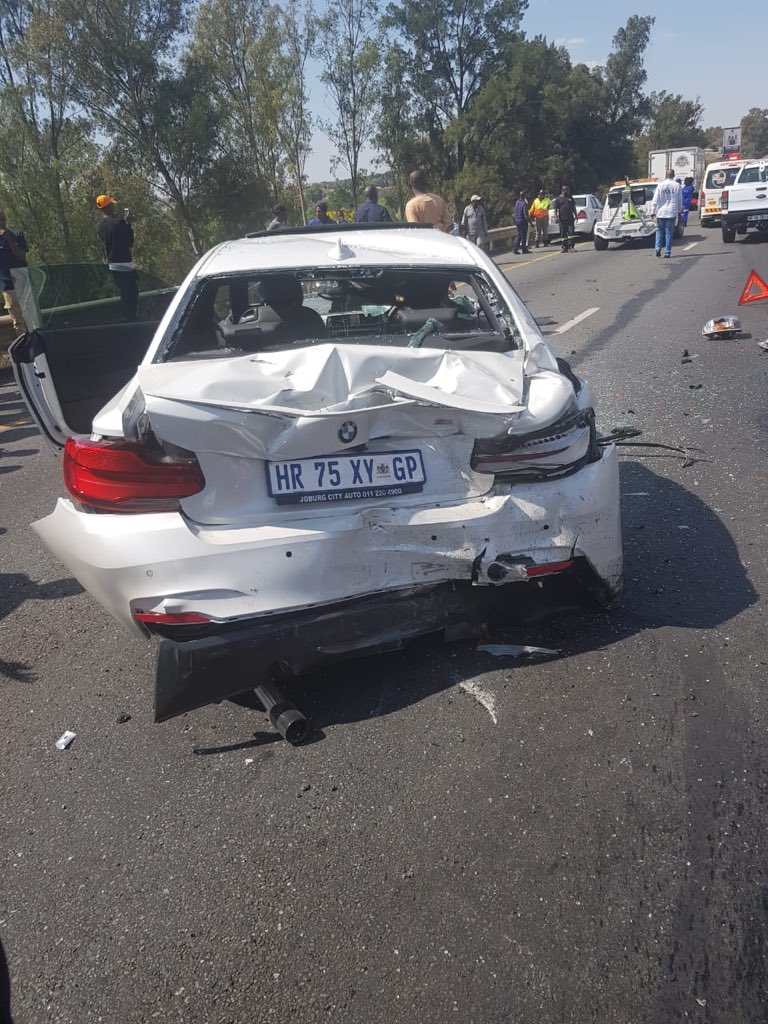

In [29]:
import base64
from mimetypes import guess_type

# Function to encode a local image into data URL 
def local_image_to_data_url(image_path):
    # Guess the MIME type of the image based on the file extension
    mime_type, _ = guess_type(image_path)
    if mime_type is None:
        mime_type = 'application/octet-stream'  # Default MIME type if none is found

    # Read and encode the image file
    with open(image_path, "rb") as image_file:
        base64_encoded_data = base64.b64encode(image_file.read()).decode('utf-8')

    # Construct the data URL
    return f"data:{mime_type};base64,{base64_encoded_data}"

# Example usage
image_path = '../../download.png'
data_url = local_image_to_data_url(image_path)
print("Data URL:", data_url)

def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")

encoded_image = encode_image("../../download.png")

In [ ]:
commandprompt = '''
    ##
    You are a insurance agent for generating damage report for calculating damage on car accidents. 
    You need to perform the following tasks based on the User query. 
    The task aims to create commands and provide the commands as output.
    An accident report can contain multiple reports of damage to a vehicle.
    You should calculate the possible damage value of the vehicle based on the reports of different types of damage.
    The damage value is calculated based on the type of damage and the extent of the damage.
    The damage value is calculated as follows:
    - A scratch has a damage value of 100.
    - A dent has a damage value of 200.
    - A broken window has a damage value of 300.
    - A flat tire has a damage value of 400.
    - A damaged engine has a damage value of 5000.
    - A damage that makes the vehicle unable to move by itself has a damage value of 10000.

    The car_id is a unique identifier for the vehicle. It should contain only alphanumeric characters and no spaces.
    The car_id should contain the brand and model of the vehicle, the color, and the license plate number. If any of these details are missing, you should use the word "unknown" instead.
    For example, a car_id could be "Toyota-Corolla-Red-ABC123" or "BMW-5Series-Blue-MM1234".
    The report_id is a unique identifier for the damage report. It should contain only alphanumeric characters and no spaces and should be unique for each report it should include the date and time of the report.
    
    The total damage value of the vehicle is the sum of the damage values of all the reports.

    If you are not able to understand the User query. Take a deep breath, think step by step. 
    Despite deliberation, if you are not able to create commands. Just answer with not able to create commands.
    The grammar defines several commands for shipping cargo. Each command takes specific arguments. 
    The '%Y-%m-%d %H:%M:%S' means string formatted datetime format.
    
    ## Here are some examples of user inputs that you can use to generate the commands defined by the grammar:

    You are able to create the following commands:
    The `create_damage_report` command takes a type of damage and the extent of the damage as arguments and creates a damage report.
        `create_damage_report (report_id, car_id)`
    
    The `report_car_damage` command takes new damage and gives it an unique identifier.
        `report_car_damage (report_id, car_id, damage_id, type, value)`
    
    The `load_box_on_truck` command takes a weight of the box as argument and adds a box to the truck. The weight is a number that represents the weight of the cargo in kilograms.
        `load_box_on_truck (truck_id, box_id, weight)`

    The `calculate_weight_of_truck` command calculated the weight of all the boxes in the truck. The weight is a number that represents the weight of the cargo in kilograms.
        `calculate_weight_of_truck (truck_id)`

    The `drive_truck_to_location` command takes a weight of the cargo in kilograms and the distance in kilometers. The weight is a number that represents the weight of the cargo in kilograms.
        `drive_truck_to_location (truck_id, weight, distance)`
    
    The `unload_box_from_truck` command takes a weight of the box as argument and unloads a box from the truck. The weight is a number that represents the weight of the cargo in kilograms.
        `unload_box_from_truck (truck_id, box_id, weight)`

    ## Here are some examples of user inputs that you can use to generate the commands defined by the grammar:

    1. For preparing a truck:
    "Please prepare a truck with ID 42."

    2. For loading a box on a truck:
    "Please load a blue box with ID 123 on the truck with ID 42."
    "Please load a red box with ID 43 on the truck with ID 42."
    "Please load a red box with ID 44 on the truck with ID 42."

    3. For calculating the weight of the truck:
    "Please calculate the weight of the truck with ID 42 after loading the boxes."
    
    4. For driving a truck to a location:
    "Please drive truck with ID 42 to the location 100 kilometers away."

    5. For unloading a box from a truck:
    "Please unload the blue box with ID 123 from the truck with ID 42."

    Remember to replace the weights, distance, dates, times, and IDs with your actual data. Also update the weight of the truck after every time a box has been loaded or unloaded.
    The dates and times should be in the format '%Y-%m-%d %H:%M:%S'.

    ## Here are some examples of how the output might look like based on the functions you provided:

    1. For preparing a truck:
    `prepare_truck("42")`

    2. For loading a box on a truck:
    `load_box_on_truck("42", "123", 5)`
    `load_box_on_truck("42", "43", 10)`
    `load_box_on_truck("42", "44", 10)`

    3. For calculating the weight of the truck:
    `calculate_weight_of_truck("42")`

    4. For driving a truck to a location:
    `drive_truck_to_location("42", 25, 100)`

    5. For unloading a box from a truck:
    `unload_box_from_truck("42", "123", 5)`

    ## Your response ought to be the command only as follows examples. However, you can prompt for input to provide the command parameters.

    1. `prepare_truck("42")`
    2. `load_box_on_truck("42", "123", 5)`
    3. `calculate_weight_of_truck("42")`
    4. `drive_truck_to_location("42", 25, 100)`
    5. `unload_box_from_truck("42", "123", 5)`

    ##
 '''

In [31]:
response = client.chat.completions.create(
    model=deployment_name,
    messages=[
        { "role": "system", "content": "You are a helpful assistant." },
        { "role": "user", "content": [  
            { 
                "type": "text", 
                "text": "Describe this picture. Extract the main article, its brand and its color." 
            },
            { 
                "type": "image_url",
                "image_url": {
                    "url": f"data:image/png;base64,{encoded_image}"
                }
            }
        ] } 
    ],
    max_tokens=2000 
)
print(response)
print(response.choices[0].message.content)

ChatCompletion(id='chatcmpl-9bVcXMT1yiwl1O9hN6xZKxCpSCCbp', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content="The picture depicts a car accident scene. The main article in the picture is a damaged car with a crushed rear end. The brand of the car is BMW, and the color of the car is white. The vehicle's damage suggests a rear-end collision, and there are other vehicles and people present at the scene who seem to be responding to the accident. The background shows a roadway with trees and other vehicles.", role='assistant', function_call=None, tool_calls=None), content_filter_results={'hate': {'filtered': False, 'severity': 'safe'}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'low'}})], created=1718726713, model='gpt-4o-2024-05-13', object='chat.completion', system_fingerprint='fp_abc28019ad', usage=CompletionUsage(completion_tokens=8